In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats
import math
from hmmlearn import hmm

plt.rcParams["figure.figsize"] = (12, 9) 

In [2]:
# load in data, convert Date to datetime type
spy = pd.read_csv("../data/spy_processed.csv")
spy["Date"] = pd.to_datetime(spy["Date"])

In [3]:
# log transform some columns
spy["volume_dev"] = np.log(spy["volume_dev"])
spy["range"] = np.log(spy["range"])
spy["var"] = np.log(spy["var"])

In [4]:
# take relevent columns
X = spy[["Date","Adj Close","ret","volume_dev","range","var"]]

In [5]:
# create HMM
class HMM:
    def __init__(self, n_comp):
        self.hmm = hmm.GaussianHMM(n_components=n_comp, covariance_type="full",n_iter=1000)
        self.n_comp = n_comp
        self.feature_names = ["ret","volume_dev","range","var"]
        self.data = X[self.feature_names]
        self.start = 0
        self.end = X.shape[0]
        self.dates = X["Date"]
        self.adj_close = X["Adj Close"]
        self.states = 0
    
    # fit the HMM to a range of indices (start, end)
    def fit_range(self, start, end, seed):
        np.random.seed(seed)
        self.hmm = hmm.GaussianHMM(n_components=self.n_comp, covariance_type="full",n_iter=1000)
        self.start = start
        self.end = end
        self.hmm.fit(self.data.iloc[start:end,:])
        self.states = self.hmm.predict(self.data.iloc[start:end,:])
    
    # predict the next close and 95% CI AFTER running fit_range
    def predict_next_close(self):
        means = self.hmm.means_[:,0]
        var = np.exp(self.hmm.means_[:,3])
        transmat = self.hmm.transmat_.transpose()
        probs = self.hmm.predict_proba(self.data.iloc[self.start:self.end,:])[self.end-self.start-1,:]
        probs = np.matmul(transmat,probs) # get a priori prob for next day
        # estimate return and its 95% CI for tomorrow
        pred_ret = np.dot(means, probs)
        pred_sd = np.sqrt(np.dot(var, probs))
        left_ret = pred_ret - 1.96*pred_sd
        right_ret = pred_ret + 1.96*pred_sd
        # calculate adj close CI for tomorrow
        pred_close = self.adj_close[self.end-1] * (1+pred_ret)
        left_ci = self.adj_close[self.end-1] * (1+left_ret)
        right_ci = self.adj_close[self.end-1] * (1+right_ret)
        return [pred_close, left_ci, right_ci]
    
    # plot the emission distribution of each feature for each component
    def plot_comp_estimates(self):
        detailed_feature_names = ["Returns", "Volume Deviation", "Range", "Volatility"]
        for i in range(len(self.feature_names)):
            plt.figure(i)
            for j in range(self.n_comp):
                mu = self.hmm.means_[j,i]
                sigma = np.sqrt(self.hmm._covars_[j,i,i])
                x = np.linspace(mu-4*sigma, mu+4*sigma, 100)
                plt.plot(x, scipy.stats.norm.pdf(x, mu, sigma), label="State {0}".format(j))
            plt.legend(fontsize=20)
            plt.title("Emission Distribution of {0}".format(detailed_feature_names[i]))
    
    # plot predicted states onto graph of adjusted close. 
    # run fit_range before running this.
    def plot_states(self, dot_size=3):
        s = self.start
        e = self.end
        plt.plot(self.dates[s:e], self.adj_close[s:e], zorder=1, c="grey")
        for i in range(self.n_comp):
            dates = self.dates[s:e][self.states==i]
            adj_close = self.adj_close[s:e][self.states==i]
            plt.scatter(dates, adj_close, zorder=2, s=dot_size, label="State {0}".format(i))
        plt.ylabel("Adjusted Close")
        plt.legend(fontsize=20, markerscale=3)
    
    # predict the next n days by training the hmm on the previous lag window of data.
    # then, predicts the stock price the following day
    # returns a data frame of predicted and actual stock prices, also calculates MSE
    # also comes with plot option
    def predict_next_n_days(self, n, begin_ind, lag, seed, show_plot=False):
        ret = []
        for i in range(n):
            self.fit_range(begin_ind-lag+i, begin_ind+i, seed=seed)
            pred = self.predict_next_close()
            actual = self.adj_close[self.end]
            ret.append({"pred":pred[0],"left_ci":pred[1],"right_ci":pred[2],"actual":actual})
        ret = pd.DataFrame(ret)
        
        mse = np.sum(np.square(ret["pred"] - ret["actual"])).mean()
        
        if show_plot:
            plt.plot(self.dates[begin_ind:begin_ind+n], ret["pred"],"o-", markersize=3, label="predicted")
            plt.plot(self.dates[begin_ind:begin_ind+n], ret["actual"], "o-", markersize=3, label="actual")
            plt.fill_between(self.dates[begin_ind:begin_ind+n], ret["left_ci"], ret["right_ci"], color="b", alpha=0.1)
            plt.ylabel("Adjusted Close")
            plt.legend(loc="lower right", fontsize=20)
            
        return mse, ret
    
    # Define function for cross validation in selecting the number of hidden states and the number of lag days
    def cross_validate_HMM(self, num_states, n, lag, val_start, seed):
        ret = []
        for s in range(len(num_states)):
            for l in range(len(lag)):
                # Train HMM model with n_comp hidden states on training data
                self.n_comp = num_states[s]
                val_preds = self.predict_next_n_days(n=n, begin_ind=val_start, lag=lag[l], seed=seed, 
                                                 show_plot=False)
                ret.append({"num_hidden_states": num_states[s], "lag": lag[l], "MSE": val_preds[0]})
                print("num_hidden_states: ", num_states[s])
                print("lag: ", lag[l])
                print("MSE: ", val_preds[0])
        ret = pd. DataFrame(ret)
        
        return ret
        
    

In [60]:
np.mean(spy.ret[6800:])

0.0007930249127349278

In [14]:
# Cross validate number of hidden states and lag to find the best HMM model
val_mod = HMM(n_comp=2)
num_states_grid = [2, 3, 4, 5, 6]
lag_grid = [600, 700, 800, 900, 1000]
val_res = val_mod.cross_validate_HMM(num_states=num_states_grid, n=600, lag=lag_grid, val_start=6199, seed=551)

num_hidden_states:  2
lag:  600
MSE:  10760.242060533068
num_hidden_states:  2
lag:  700
MSE:  10740.288500951321
num_hidden_states:  2
lag:  800
MSE:  10706.723735687276
num_hidden_states:  2
lag:  900
MSE:  10691.988087664358
num_hidden_states:  2
lag:  1000
MSE:  10690.851322056835
num_hidden_states:  3
lag:  600
MSE:  10704.912783528429
num_hidden_states:  3
lag:  700
MSE:  10752.79772800743
num_hidden_states:  3
lag:  800
MSE:  10778.534853074701
num_hidden_states:  3
lag:  900
MSE:  10763.451990455309
num_hidden_states:  3
lag:  1000
MSE:  10739.825686617782
num_hidden_states:  4
lag:  600
MSE:  10947.010917047897
num_hidden_states:  4
lag:  700
MSE:  10884.350665000651
num_hidden_states:  4
lag:  800
MSE:  10765.453851836428
num_hidden_states:  4
lag:  900
MSE:  10690.624368513312
num_hidden_states:  4
lag:  1000
MSE:  10778.883147970966
num_hidden_states:  5
lag:  600
MSE:  10886.979526859042
num_hidden_states:  5
lag:  700
MSE:  10764.208914159213
num_hidden_states:  5
lag:  8

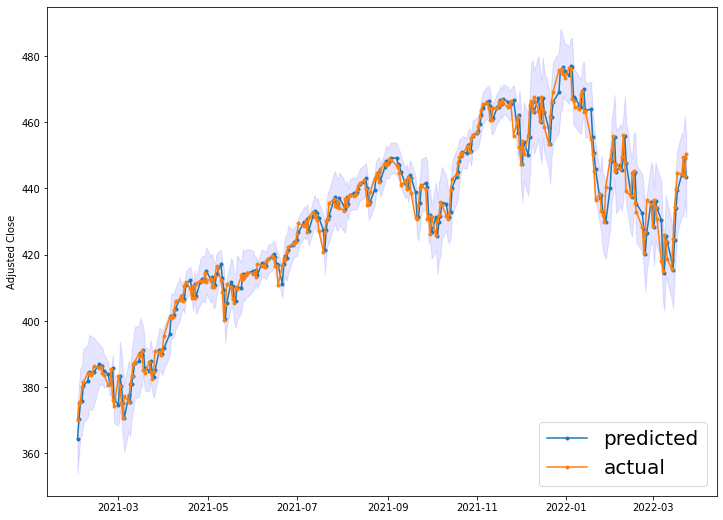

In [15]:
# Train model selected by CV and make predictions on test data
mod = HMM(n_comp=4)
res = mod.predict_next_n_days(n=290, begin_ind=6800, lag=900, seed=551, show_plot=True)

We see that the actual prices and the predicted prices from the HMM are pretty close to each other.

In [16]:
# Obtain MSE of final model
res[0]

4810.0796847361435

In [51]:
# coverage of CI
np.mean((res[1]["left_ci"] < res[1]["actual"]) & (res[1]["actual"] < res[1]["right_ci"]))

0.9344827586206896

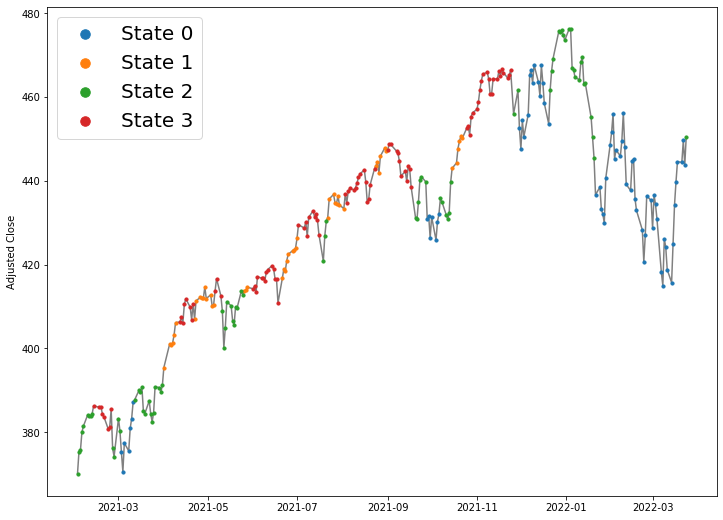

In [17]:
mod.fit_range(6800,7090, seed=551)
mod.plot_states(dot_size=10)

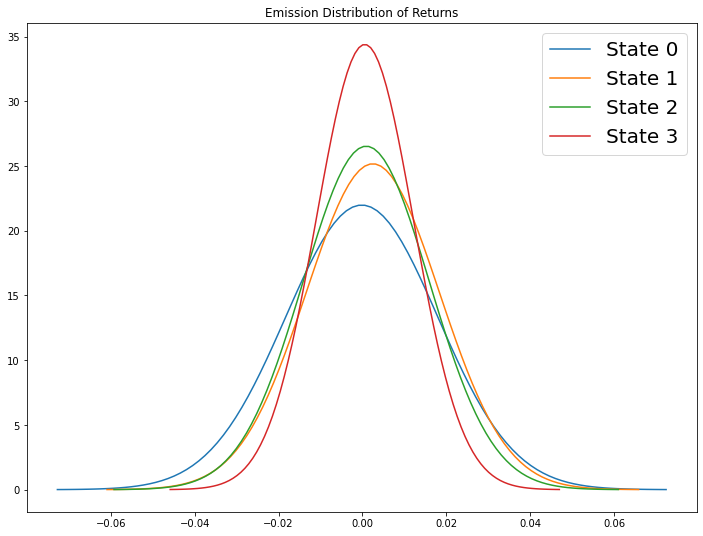

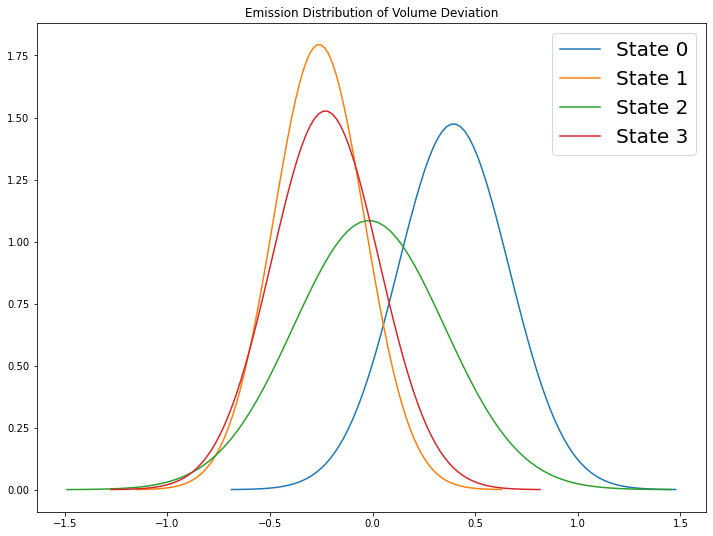

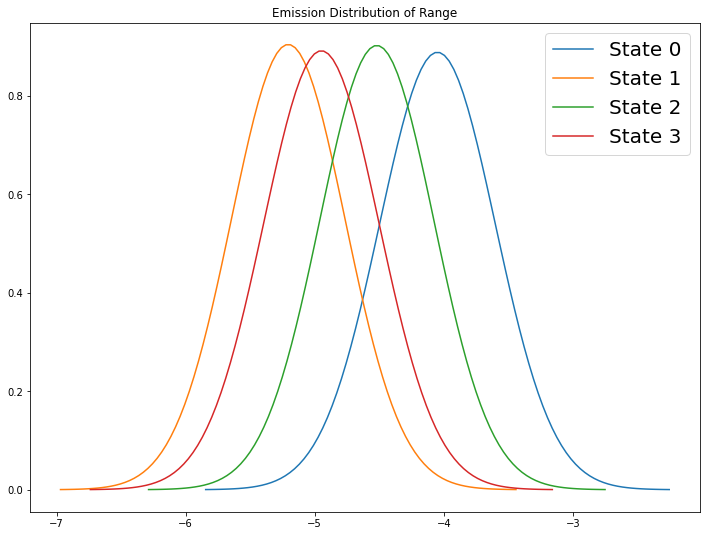

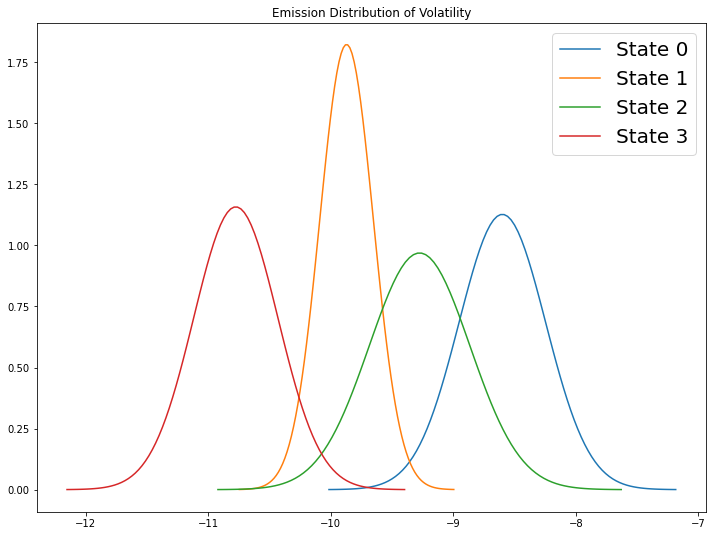

In [18]:
mod.plot_comp_estimates()

In [58]:
# means of above distributions
np.round(mod.hmm.means_,5)

array([[-1.500000e-04,  3.946900e-01, -4.048890e+00, -8.599550e+00],
       [ 2.490000e-03, -2.605300e-01, -5.205460e+00, -9.871570e+00],
       [ 9.100000e-04, -1.715000e-02, -4.518980e+00, -9.275410e+00],
       [ 5.700000e-04, -2.297100e-01, -4.948870e+00, -1.077611e+01]])

In [41]:
# variances of above distributions
[np.diag(mod.hmm.covars_[i,:,:]) for i in range(4)]

[array([0.00032921, 0.07319798, 0.20174801, 0.12528261]),
 array([0.00025108, 0.04941816, 0.19474543, 0.04790349]),
 array([0.00022602, 0.13525835, 0.19562065, 0.16947493]),
 array([1.34526576e-04, 6.82755619e-02, 2.00374232e-01, 1.18731385e-01])]

With the final model, we notice that the mean for the emission distribution of returns for mostly all of the 6 states are centered at zero with state 2 having the smallest variance and state 3 having the largest variance. For emission distribution of range, we notice the same pattern where state 3 has the highest mean range and state 2 has the lowest mean range. The mean volume deviation for the emission distributionis highest for state 3 and smallest for state 1. Lastly, in terms of volatility, state 3 has the highest mean for the emission distribution and state 2 has the lowest mean. We also note that the emission distribution of the states based on this variable are more distinct compared to the other variables.